In [1]:
%load_ext autoreload
%autoreload 2
import h5py
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse.linalg
rng=np.random.default_rng()
import tqdm.notebook
import sklearn.ensemble
import torch
import pickle
%matplotlib inline

plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),
})


import torch_geometric
import sys

import pytorch_lightning as pl
import pllog
import ipywidgets
import sklearn.neighbors

original_url= "https://datadryad.org/stash/downloads/file_stream/67671"
csv_location='/data/spatial/moffit_merfish/original_file.csv'
h5ad_location='/data/spatial/moffit_merfish/original_file.h5ad'
connectivity_matrix_template='/data/spatial/moffit_merfish/connectivity_%dneighbors.h5ad'
genetypes_location='/data/spatial/moffit_merfish/genetypes.pkl'

def construct_dense_relu_network(sizes, use_batchnorm=True, final_relu=False):
    lst = []
    for i in range(len(sizes) - 1):
        lst.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
        if use_batchnorm:
            lst.append(torch.nn.BatchNorm1d(sizes[i + 1]))
        lst.append(torch.nn.ReLU())
    if not final_relu:
        lst = lst[:-1]

    return torch.nn.Sequential(*lst)


class DenseReluGMMConvNetwork(torch.nn.Module):
    def __init__(self, sizes, use_batchnorm=True, final_relu=False, **gmmargs):
        super().__init__()
        self.use_batchnorm = use_batchnorm
        self.final_relu = final_relu

        # construct a bunch of gmms
        lst = []
        for i in range(len(sizes) - 1):
            gmmc = torch_geometric.nn.GMMConv(sizes[i], sizes[i + 1], **gmmargs)
            lst.append(gmmc)
        self.gmms = torch.nn.ModuleList(lst)

        # and some linears ("self-edges")
        lst = []
        for j in range(len(sizes) - 1):
            lst.append(torch.nn.Linear(sizes[j], sizes[j + 1], bias=False))
        self.linears = torch.nn.ModuleList(lst)

        # construct batchnorm layers we need
        if use_batchnorm:
            self.batchnorms = torch.nn.ModuleList(
                [torch.nn.BatchNorm1d(s) for s in sizes[1:]]
            )

    def forward(self, vals, edges, pseudo):
        from torch.nn import functional as fcl
        for i, (dense, gmmlayer) in enumerate(zip(self.linears, self.gmms)):
            vals = gmmlayer(vals, edges, pseudo) + dense(vals)

            # do batchnorm
            if self.use_batchnorm:
                vals = self.batchnorms[i](vals)

            # do relu (or not, if final_relu=False and we're on the last layer)
            if self.final_relu or (i != len(self.gmms) - 1):
                vals = fcl.relu(vals)

        return vals
    
def oh_encode(lst):
    lst=np.array(lst)
    group_names=np.unique(lst)
    group_indexes=np.zeros((len(lst),len(group_names)),dtype=bool)
    for i,nm in enumerate(group_names):
        group_indexes[lst==nm,i]=True
    return group_names,group_indexes

# load data

In [2]:
# load data
ad=anndata.read_h5ad(h5ad_location)
gene_lookup={x:i for (i,x) in enumerate(ad.var.index)}

with open(genetypes_location,'rb') as f:
    genetypes=pickle.load(f)

cell_classes,cell_class_onehots=oh_encode(ad.obs['Cell_class'])

# ttsplit

In [3]:
trainset=(ad.obs['Animal_ID']>=2)&(ad.obs['Animal_ID']<=4)
testset=ad.obs['Animal_ID']==1

# adj

  0%|          | 0/181 [00:00<?, ?it/s]

Text(0.5, 0, 'neighbors per node')

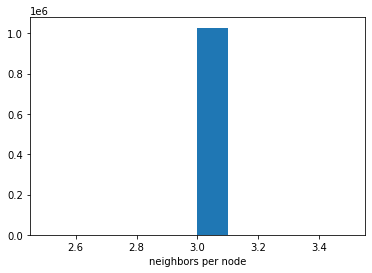

In [4]:
row=np.zeros(0,dtype=int)
col=np.zeros(0,dtype=int)
nneigh=3

tissue_ids=np.unique(ad.obs['Tissue_ID'])

for tid in tqdm.notebook.tqdm(tissue_ids):
    good=ad.obs['Tissue_ID']==tid
    pos=np.array(ad.obs[good][['Centroid_X','Centroid_Y']])
    p=sklearn.neighbors.BallTree(pos)
    # E=sklearn.neighbors.radius_neighbors_graph(pos,thresh,mode='connectivity')
    E=sklearn.neighbors.kneighbors_graph(pos,nneigh,mode='connectivity')
    idxs=np.where(good)[0]
    col=np.r_[col,idxs[E.tocoo().col]]
    row=np.r_[row,idxs[E.tocoo().row]]
    
connectivity_matrix=sp.sparse.coo_matrix((np.ones(len(col)),(row,col)),shape=(ad.X.shape[0],ad.X.shape[0])).tocsr()
plt.hist(np.array(np.sum(connectivity_matrix,axis=1)).ravel())
plt.xlabel("neighbors per node")

# make dataloaders

In [5]:
training_tissue_ids=np.unique(ad.obs['Tissue_ID'][trainset])
testing_tissue_ids=np.unique(ad.obs['Tissue_ID'][testset])

torch.Size([6509, 171]) torch.Size([6509, 2]) torch.Size([2, 19527]) torch.Size([6509, 171])
torch.float32 torch.float32 torch.int64


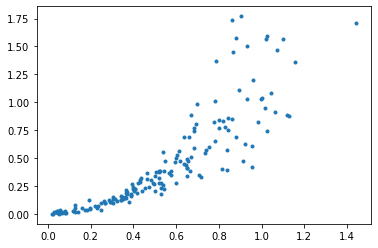

In [6]:
good=~np.isnan(ad.X).any(axis=0)
good=good&(~np.array([x.startswith('Blank_') for x in ad.var.index]))

vischance=.5
# vischance=1.0

def tid2d(tid):
    mask=ad.obs['Tissue_ID']==tid
    exprs=np.log1p(ad.X[ad.obs['Tissue_ID']==tid])[:,good]
    coo=connectivity_matrix[mask][:,mask].tocoo()
    edge=torch.tensor(np.c_[coo.row,coo.col].T,dtype=torch.long)
    pos=torch.tensor(np.c_[ad.obs['Centroid_X'][mask],ad.obs['Centroid_Y'][mask]],dtype=torch.float32)
    ctinfo=torch.tensor(cell_class_onehots[mask],dtype=torch.bool)
     
    
    fullX=torch.cat([torch.tensor(exprs,dtype=torch.float32),ctinfo],axis=1)
    
    
    visible=rng.random(fullX.shape)<vischance
    visible[:,exprs.shape[1]:]=True
    visible=torch.tensor(visible,dtype=torch.float32)
    
    return torch_geometric.data.Data(x=fullX,y=visible,edge_index=edge,pos=pos).cuda()

tid=0
foo=tid2d(0)
print(foo.x.shape,foo.pos.shape,foo.edge_index.shape,foo.y.shape)
print(foo.x.dtype,foo.pos.dtype,foo.edge_index.dtype)
plt.plot(np.std(foo.x.cpu().numpy(),axis=0),np.mean(foo.x.cpu().numpy(),axis=0),'.')

In [7]:
training_tissues_cuda=[tid2d(tid) for tid in training_tissue_ids]
testing_tissues_cuda=[tid2d(tid) for tid in testing_tissue_ids]
training_dl=torch_geometric.data.DataLoader([x for x in training_tissues_cuda],batch_size=1)
testing_dl=torch_geometric.data.DataLoader([x for x in testing_tissues_cuda],batch_size=1)

# unspatialized training/test data (for ridge models)

In [8]:
train_exprs=np.concatenate([tiss.x.detach().cpu().numpy() for tiss in training_tissues_cuda],axis=0)
train_visible=np.concatenate([tiss.y.detach().cpu().numpy() for tiss in training_tissues_cuda],axis=0)
trainX=train_exprs*train_visible
trainY=train_exprs

test_exprs=np.concatenate([tiss.x.detach().cpu().numpy() for tiss in testing_tissues_cuda],axis=0)
test_visible=np.concatenate([tiss.y.detach().cpu().numpy() for tiss in testing_tissues_cuda],axis=0)
testX=test_exprs*test_visible
testY=test_exprs

mu=np.mean(trainX,axis=0)
sig=np.std(trainX,axis=0)
trainX=(trainX-mu)/sig
testX=(testX-mu)/sig

In [9]:
models=[]
train_maes=[]
test_maes=[]
tq=tqdm.notebook.trange(trainY.shape[1])
for i in tq:
    model=sklearn.linear_model.Ridge(alpha=1.0)
    # model=sklearn.ensemble.HistGradientBoostingRegressor(loss='absolute_error')#l2_regularization=1000.0)
    # model=sklearn.linear_model.HuberRegressor(epsilon=30.0)
    model.fit(trainX,trainY[:,i])
    train_maes.append(np.mean(np.abs(model.predict(trainX)-trainY[:,i])))
    test_maes.append(np.mean(np.abs(model.predict(testX)-testY[:,i])))
    models.append(model)
    tq.set_description(str(np.mean(test_maes)))
ridge_test_maes=test_maes

  0%|          | 0/171 [00:00<?, ?it/s]

In [10]:
models=[]
train_maes=[]
test_maes=[]
tq=tqdm.notebook.trange(trainY.shape[1])
for i in tq:
    model=sklearn.linear_model.Ridge(alpha=1.0)
    # model=sklearn.ensemble.HistGradientBoostingRegressor(loss='absolute_error')#l2_regularization=1000.0)
    # model=sklearn.linear_model.HuberRegressor(epsilon=30.0)
    model.fit(trainX,trainY[:,i])
    train_maes.append(np.mean(np.abs(model.predict(trainX)-trainY[:,i])))
    test_maes.append(np.mean(np.abs(model.predict(testX)-testY[:,i])))
    models.append(model)
    tq.set_description(str(np.mean(test_maes)))
ridge_test_maes=test_maes

  0%|          | 0/171 [00:00<?, ?it/s]

Text(0, 0.5, 'test')

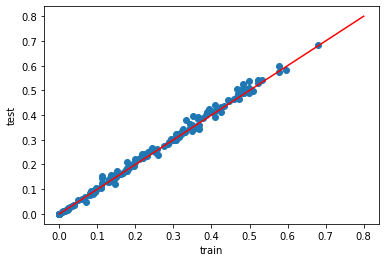

In [11]:
plt.scatter(train_maes,test_maes)
plt.plot([0,.8],[0,.8],'r-')
plt.xlabel("train")
plt.ylabel('test')

# unspatialized (for boost)

In [16]:
train_exprs=np.concatenate([tiss.x.detach().cpu().numpy() for tiss in training_tissues_cuda],axis=0)
train_visible=np.concatenate([tiss.y.detach().cpu().numpy() for tiss in training_tissues_cuda],axis=0)
trainX=np.where(train_visible,train_exprs,np.nan)
trainY=train_exprs

test_exprs=np.concatenate([tiss.x.detach().cpu().numpy() for tiss in testing_tissues_cuda],axis=0)
test_visible=np.concatenate([tiss.y.detach().cpu().numpy() for tiss in testing_tissues_cuda],axis=0)
testX=np.where(test_visible,test_exprs,np.nan)
testY=test_exprs

# mu=np.mean(trainX,axis=0)
# sig=np.std(trainX,axis=0)
# trainX=(trainX-mu)/sig
# testX=(testX-mu)/sig

In [17]:
models=[]
train_maes=[]
test_maes=[]
tq=tqdm.notebook.trange(trainY.shape[1])
for i in tq:
    model=sklearn.ensemble.HistGradientBoostingRegressor(loss='absolute_error')#l2_regularization=1000.0)
    model.fit(trainX,trainY[:,i])
    train_maes.append(np.mean(np.abs(model.predict(trainX)-trainY[:,i])))
    test_maes.append(np.mean(np.abs(model.predict(testX)-testY[:,i])))
    models.append(model)
    tq.set_description(str(np.mean(test_maes)))
boost_test_maes=test_maes

  0%|          | 0/171 [00:00<?, ?it/s]

# unspatial net

In [26]:
class AutoencodingRegularizedPredictor(pl.LightningModule):
    '''
    X -> latent -> X,Y
    '''
    def __init__(self,xsize,sizes_encoder,size_latent,sizes_decoder,lr,weight_decay):
        super().__init__()
        
        self.weight_decay=weight_decay
        
        self.encoder_network = construct_dense_relu_network(
            [xsize] + sizes_encoder + [size_latent],
        )

        self.decoder_network = construct_dense_relu_network(
            [size_latent] + sizes_decoder+[xsize],
            final_relu=False
        )
        self.lr=lr
        
    def forward(self,x,y,edge,pos):
        z=self.encoder_network(x*y)
        xpred=self.decoder_network(z)
        return z,xpred
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr=self.lr,weight_decay=self.weight_decay)
    
    def loss(self,x,y,edge,pos):
        loss=self.lossper(x,y,edge,pos)
        return torch.mean(loss)
    
    def lossper(self,x,y,edge,pos):
        z,xpred=self.forward(x,y,edge,pos)
        return torch.abs(x-xpred)
   
    def expand_batch(self,batch):
        return batch.x,batch.y,batch.edge_index,batch.pos

    def training_step(self,batch,batch_idx):
        x,y,edge,pos=self.expand_batch(batch)
        loss=torch.mean(self.lossper(x,y,edge,pos))
        self.log('trainloss',loss)
        return loss
    
    def validation_step(self,batch,batch_idx):
        x,y,edge,pos=self.expand_batch(batch)
        loss=torch.mean(self.lossper(x,y,edge,pos))
        self.log('testloss',loss)
        return loss
    

In [27]:
model=AutoencodingRegularizedPredictor(
    tid2d(0).x.shape[1],
    [256,256],
    128,
    [256,256],
    1e-3, # learnign rate
    1e-6, # weight decay 
).cuda()

print('initial loss',model.loss(*model.expand_batch(next(iter(training_dl)))))

initial loss tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)


In [28]:
logger=pllog.DictLogger()

def disp():
    return logger.lowest_yet('testloss')

epochs=400
model.train()
with tqdm.notebook.tqdm(total=epochs*len(training_tissue_ids)) as tq:
    bar=pllog.LitProgressBar(tq,cb=disp)
    trainer=pl.Trainer(gpus=1,max_epochs=epochs,logger=logger,log_every_n_steps=1,callbacks=[bar])
    trainer.fit(model,training_dl,testing_dl)
model=model.cuda()
model.eval();

  0%|          | 0/9200 [00:00<?, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name            | Type       | Params
-----------------------------------------------
0 | encoder_network | Sequential | 144 K 
1 | decoder_network | Sequential | 144 K 
-----------------------------------------------
288 K     Trainable params
0         Non-trainable params
288 K     Total params
1.153     Total estimated model params size (MB)
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/roko/spatial/scratch/DictLogger/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWa

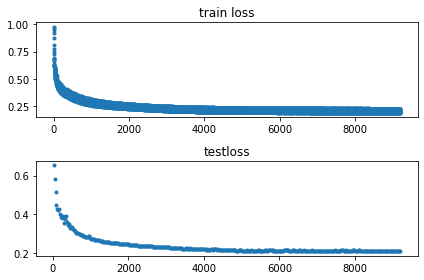

In [29]:
plt.subplot(2,1,1)
steps,vals=logger.collate('trainloss')
plt.plot(steps,vals,'.')
plt.title("train loss")

plt.subplot(2,1,2)
steps,vals=logger.collate('testloss')
# plt.plot(steps,vals,'.')
plt.plot(steps,vals,'.')
plt.title("testloss")

plt.tight_layout()

In [30]:
training_pred_losses=np.sum(
    [np.sum(model.lossper(*model.expand_batch(b)).detach().cpu().numpy(),axis=0) for b in training_dl],
    axis=0
)/trainX.shape[0]

testing_pred_losses=np.sum(
    [np.sum(model.lossper(*model.expand_batch(b)).detach().cpu().numpy(),axis=0) for b in testing_dl],
    axis=0
)/testX.shape[0]

print(np.mean(training_pred_losses))
print(np.mean(testing_pred_losses))

0.20508377460392702
0.21267175257316864


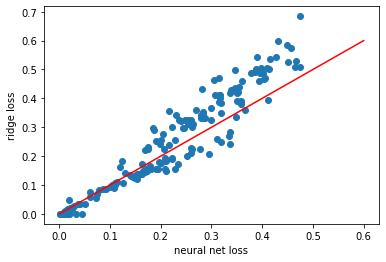

In [31]:
plt.scatter(testing_pred_losses,ridge_test_maes)
plt.xlabel("neural net loss")
plt.ylabel("ridge loss")
plt.plot([0,.6],[0,.6],'r-')

# spatial net

In [32]:
def calc_pseudo(edge_index, pos):
    """
    Calculate pseudo
    Input:
      - edge_index, an (N_edges x 2) long tensor indicating edges of a graph
      - pos, an (N_vertices x 2) float tensor indicating coordinates of nodes
    Output:
      - pseudo, an (N_edges x 2) float tensor indicating edge-values
        (to be used in graph-convnet)
    """
    coord1 = pos[edge_index[0]]
    coord2 = pos[edge_index[1]]
    edge_dir = coord2 - coord1
    rho = torch.sqrt(edge_dir[:, 0] ** 2 + edge_dir[:, 1] ** 2).unsqueeze(-1)
    theta = torch.atan2(edge_dir[:, 1], edge_dir[:, 0]).unsqueeze(-1)
    return (rho-20.0)/15.0

class AutoencodingRegularizedGraphConvolutionalPredictorRho(AutoencodingRegularizedPredictor):
    '''
    X -> latent -> X,Y
    '''
    def __init__(self,xsize,sizes_encoder,size_latent,sizes_decoder,lr,weight_decay,
                 kernel_size,helper=None):
        pl.LightningModule.__init__(self)
        
        self.helper=helper
        
        self.weight_decay=weight_decay
        
        self.encoder_network = DenseReluGMMConvNetwork(
            [xsize] + sizes_encoder + [size_latent],
            dim=1,
            kernel_size=kernel_size,
        )
        self.decoder_network = DenseReluGMMConvNetwork(
            [size_latent] + sizes_decoder + [xsize],
            dim=1,
            kernel_size=kernel_size,final_relu=True
        )
        self.lr=lr
        
    def forward(self,x,y,edge,pos):
        pseudo = calc_pseudo(edge, pos)
        z=self.encoder_network(x*y,edge,pseudo)
        xpred=self.decoder_network(z,edge,pseudo)
        
        if self.helper is not None:
            xhelp=self.helper.forward(x,y,edge,pos)[1]
            return z,xpred*.1+xhelp
        else:
            return z,xpred
   

In [33]:
kernel_size=4
gmodel=AutoencodingRegularizedGraphConvolutionalPredictorRho(
    tid2d(0).x.shape[1],
    [256],
    128,
    [256],
    1e-3, # learnign rate
    1e-6, # weight decay 
    kernel_size,
    helper=None#model
).cuda()

print('initial loss',gmodel.loss(*gmodel.expand_batch(next(iter(training_dl)))))

initial loss tensor(0.5850, device='cuda:0', grad_fn=<MeanBackward0>)


-0.112253204


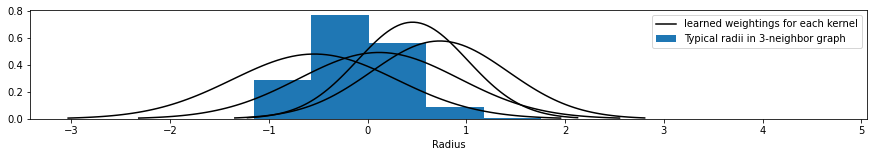

In [34]:
plt.gcf().set_size_inches(15,2)

# x,y,edge,pos=gmodel.expand_batch(testing_tissues_cuda[1])
x,y,edge,pos=gmodel.expand_batch(training_tissues_cuda[3])
example_pseudos=calc_pseudo(edge,pos).detach().cpu().numpy()
print(np.mean(example_pseudos))

A=gmodel.encoder_network.gmms[0]
mus=A.mu.detach().cpu().numpy().ravel()
sigs=A.sigma.detach().cpu().numpy().ravel()
label='learned weightings for each kernel'
for (mu,sig) in zip(mus,sigs):
    xs=np.r_[mu-3*sig:mu+3*sig:100j]
    plt.plot(xs,sp.stats.norm.pdf(xs,loc=mu,scale=np.abs(sig)),'k-',label=label)
    label=None
plt.xlabel("Radius")

plt.hist(example_pseudos,density=True,label='Typical radii in 3-neighbor graph')

plt.legend()

In [35]:
glogger=pllog.DictLogger()

def disp():
    low1=glogger.lowest_yet('testloss')
    low2=glogger.lowest_yet('trainloss')
    return f'test {low1:.3f}, train {low2:.3f}'

epochs=400
gmodel.train()
with tqdm.notebook.tqdm(total=epochs*len(training_tissue_ids)) as tq:
    bar=pllog.LitProgressBar(tq,cb=disp)
    trainer=pl.Trainer(gpus=1,max_epochs=epochs,logger=glogger,log_every_n_steps=1,callbacks=[bar])
    trainer.fit(gmodel,training_dl,testing_dl)
gmodel=gmodel.cuda()
gmodel.eval();

  0%|          | 0/9200 [00:00<?, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name            | Type                    | Params
------------------------------------------------------------
0 | encoder_network | DenseReluGMMConvNetwork | 460 K 
1 | decoder_network | DenseReluGMMConvNetwork | 460 K 
------------------------------------------------------------
920 K     Trainable params
0         Non-trainable params
920 K     Total params
3.684     Total estimated model params size (MB)
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/roko/spatial/scratch/DictLogger/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/si

(0.15, 0.3)

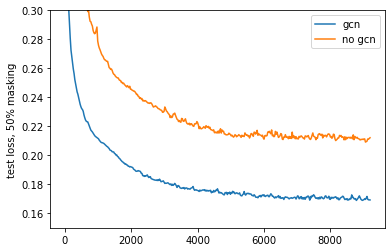

In [36]:

steps,vals=glogger.collate('testloss')
plt.plot(steps,vals,label='gcn')


steps,vals=logger.collate('testloss')
plt.plot(steps,vals,label='no gcn')

plt.legend()
plt.ylabel("test loss, 50% masking")

plt.ylim(.15,.3)

In [37]:
training_pred_glosses=np.sum(
    [np.sum(gmodel.lossper(*gmodel.expand_batch(b)).detach().cpu().numpy(),axis=0) for b in training_dl],
    axis=0
)/trainX.shape[0]

testing_pred_glosses=np.sum(
    [np.sum(gmodel.lossper(*gmodel.expand_batch(b)).detach().cpu().numpy(),axis=0) for b in testing_dl],
    axis=0
)/testX.shape[0]

print(np.mean(training_pred_losses))
print(np.mean(testing_pred_losses))

0.20508377460392702
0.21267175257316864


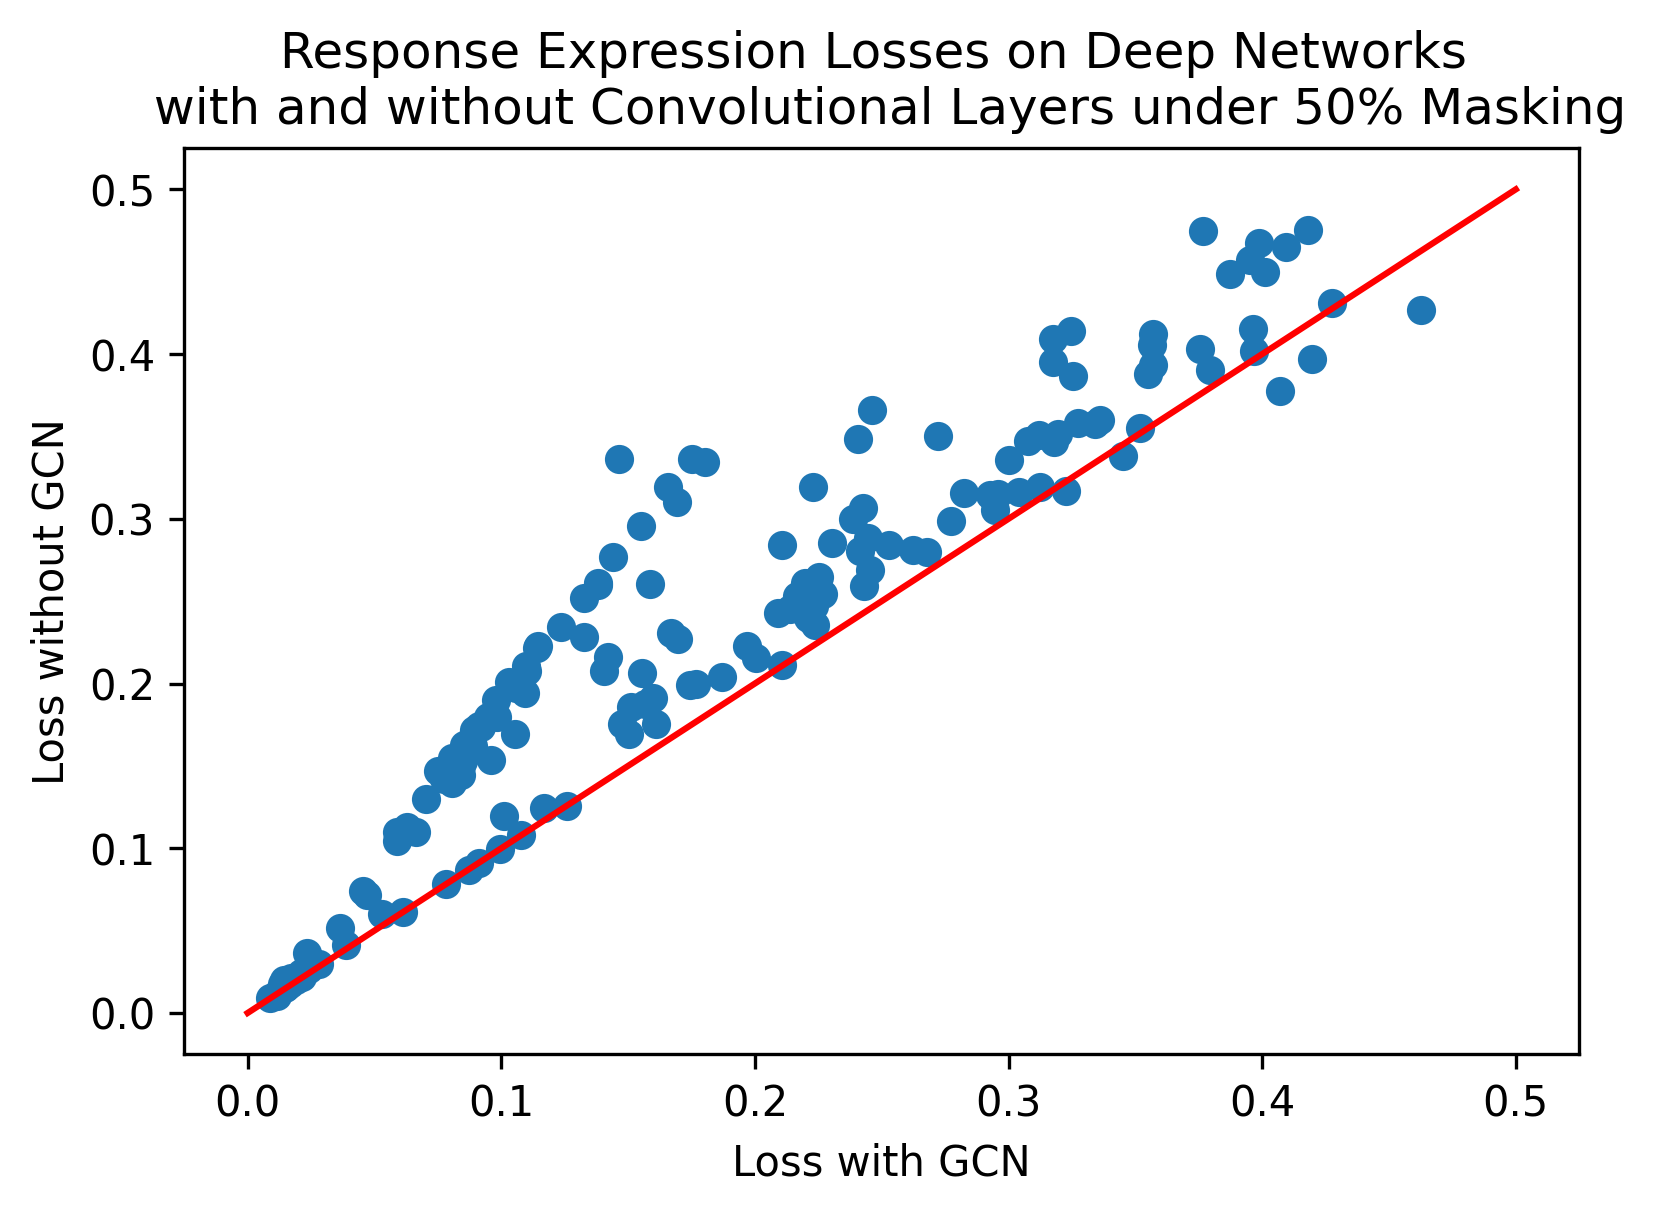

In [38]:
plt.gcf().set_dpi(300)
plt.scatter(testing_pred_glosses[:-16],testing_pred_losses[:-16])
plt.xlabel("Loss with GCN")
plt.ylabel("Loss without GCN")
plt.title("Response Expression Losses on Deep Networks \n with and without Convolutional Layers under 50% Masking")
plt.plot([0,.5],[0,.5],'r-')
plt.savefig("MSSISS_figure.png")

In [47]:
import seaborn as sns

-0.112253204


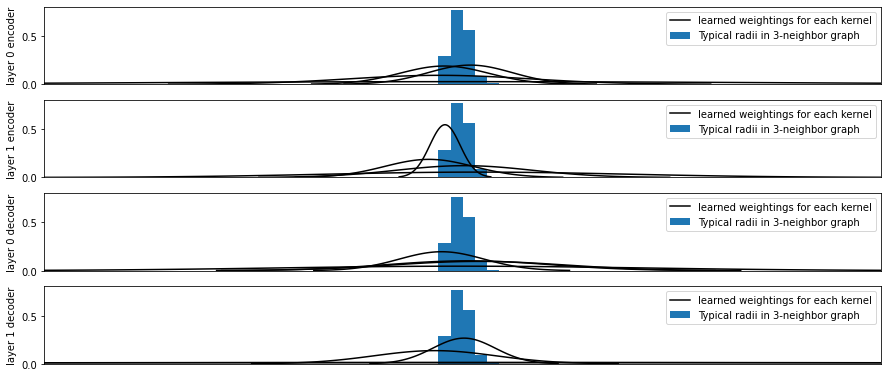

In [48]:
plt.gcf().set_size_inches(15,10)

# x,y,edge,pos=gmodel.expand_batch(testing_tissues_cuda[1])
x,y,edge,pos=gmodel.expand_batch(training_tissues_cuda[3])
example_pseudos=calc_pseudo(edge,pos).detach().cpu().numpy()
print(np.mean(example_pseudos))

for i,A in enumerate((list(gmodel.encoder_network.gmms)+list(gmodel.decoder_network.gmms))):
    plt.subplot(6,1,i+1)
    mus=A.mu.detach().cpu().numpy().ravel()
    sigs=np.abs(1.0/A.sigma.detach().cpu().numpy().ravel())
    label='learned weightings for each kernel'
    for (mu,sig) in zip(mus,sigs):
        xs=np.r_[mu-3*sig:mu+3*sig:100j]
        plt.plot(xs,sp.stats.norm.pdf(xs,loc=mu,scale=sig),'k-',label=label)
        label=None
    plt.xlabel("Radius")
    
    ng=len(gmodel.encoder_network.gmms)
    if i<ng:
        plt.ylabel(f'layer {i} encoder')
    else:
        plt.ylabel(f'layer {i-ng} decoder')

    plt.hist(example_pseudos,density=True,label='Typical radii in 3-neighbor graph')

    plt.legend()
    
    if i!=4:
        plt.xticks([])
        plt.xlabel('')
    
    plt.xlim(-20,20)